In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

plt.style.use('seaborn')
sns.set_palette('cubehelix')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams["axes.grid"] = True
plt.rcParams['figure.figsize'] = [5, 3.5]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["axes.formatter.limits"] = -10000, 10000
warnings.simplefilter(action='ignore', category=FutureWarning)

!pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd
!pip install pyfolio
import pyfolio as pf

import numpy as np 
import scipy.optimize as sco

C:\Users\minjae908\Anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [3]:
RISKY_ASSETS = ['AAPL', 'IBM', 'MSFT']
RISKY_ASSETS.sort()
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'

num_ports = 10 ** 5 
num_days = 252 
num_assets = len(RISKY_ASSETS)

df_prices = yf.download(RISKY_ASSETS, start=START_DATE, end=END_DATE, adjusted=True)

df_returns = df_prices['Adj Close'].pct_change().dropna()

avg_returns = df_returns.mean() * num_days # 연율화

cov_mat = df_returns.cov() * num_days # 연율화

[*********************100%***********************]  3 of 3 completed


In [5]:
def get_port_rtn(weights,avg_rtns): 
    return np.sum(avg_rtns * weights)

def get_port_vol(weights, avg_rtns, cov_mat): 
    return np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))

def get_efficient_frontier(avg_rtns, cov_mat, rtns_range): 

    efficient_portfolios = []

    n_assets = len(avg_returns) 
    args = (avg_returns, cov_mat)
    bounds = tuple((0,1) for assets in range(n_assets)) 
    initial_guess = n_assets * [1. / n_assets, ] # length: 4 assets with 0.25 

    for ret in rtns_range: 
        constraints = ({'type': 'eq', 
                       'fun': lambda x: get_port_rtn(x, avg_rtns) - ret}, 
                      {'type': 'eq', 
                       'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_port_vol, initial_guess, 
                                           args = args, method = 'SLSQP', 
                                           constraints = constraints,
                                           bounds = bounds)
        efficient_portfolios.append(efficient_portfolio)
    
    return efficient_portfolios     

In [6]:
rtns_range = np.linspace(-0.22, 0.32, 200)

efficient_portfolios = get_efficient_frontier(avg_returns, cov_mat, rtns_range)

vols_range = [x['fun'] for x in efficient_portfolios]

# Minimum Variance Portfolio

In [7]:
min_vol_ind = np.argmin(vols_range) 
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']

min_vol_portf = {'Return': min_vol_portf_rtn,
                 'Volatility': min_vol_portf_vol, 
                 'Sharpe Ratio': (min_vol_portf_rtn / 
                                  min_vol_portf_vol)}

# min_vol_portf

print('Minimum Volatility portfolio ----')
print('Performance')

for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')
for x, y in zip(RISKY_ASSETS, efficient_portfolios[min_vol_ind]['x']):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
Return: -12.50% Volatility: 22.58% Sharpe Ratio: -55.37% 
Weights
AAPL: 28.04% IBM: 58.98% MSFT: 12.98% 

In [8]:
min_vol_port_weights = efficient_portfolios[min_vol_ind]['x']
min_vol_port_weights

array([0.28038065, 0.58980141, 0.12981793])

# Maximum Sharpe Ratio Portfolio

In [9]:
# min - sharpe ratio (negative sharpe ratio)
# max sharpe ratio 

def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate): 
    portf_returns = np.sum(avg_rtns * w) 
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    portf_sharpe_ratio = (portf_returns - rf_rate) / portf_volatility 
    return -portf_sharpe_ratio 

In [10]:
n_assets = len(avg_returns) 
RF_RATE = 0 

args = (avg_returns, cov_mat, RF_RATE)
constraints = ({'type': 'eq', 
                'fun': lambda x: np.sum(x)-1})
bounds = tuple((0,1) for asset in range(n_assets)) 
initial_guess = n_assets * [1. / n_assets]

max_sharpe_portf = sco.minimize(neg_sharpe_ratio, 
                                x0=initial_guess, 
                                args=args, 
                                method='SLSQP', 
                                bounds=bounds, 
                                constraints=constraints)

In [13]:
max_sharpe_portf_w = max_sharpe_portf['x']
max_sharpe_portf = {'Return': get_port_rtn(max_sharpe_portf_w, 
                                            avg_returns),
                    'Volatility': get_port_vol(max_sharpe_portf_w, 
                                                avg_returns, 
                                                cov_mat),
                    'Sharpe Ratio': -max_sharpe_portf['fun']}

# max_sharpe_portf

print('Maximum Sharpe Ratio portfolio ----')
print('Performance')

for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')
for x, y in zip(RISKY_ASSETS, max_sharpe_portf_w):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
Return: 21.46% Volatility: 28.35% Sharpe Ratio: 75.68% 
Weights
AAPL: 0.00% IBM: 0.00% MSFT: 100.00% 

In [14]:
max_SR_port_weights = max_sharpe_portf_w
max_SR_port_weights

array([5.55111512e-17, 0.00000000e+00, 1.00000000e+00])

## Simultations

In [15]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=42):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    '''
    np.random.seed(random_seed)

    dt = T/N 
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis =1)

    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))

    S_t = s_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)

    return S_t

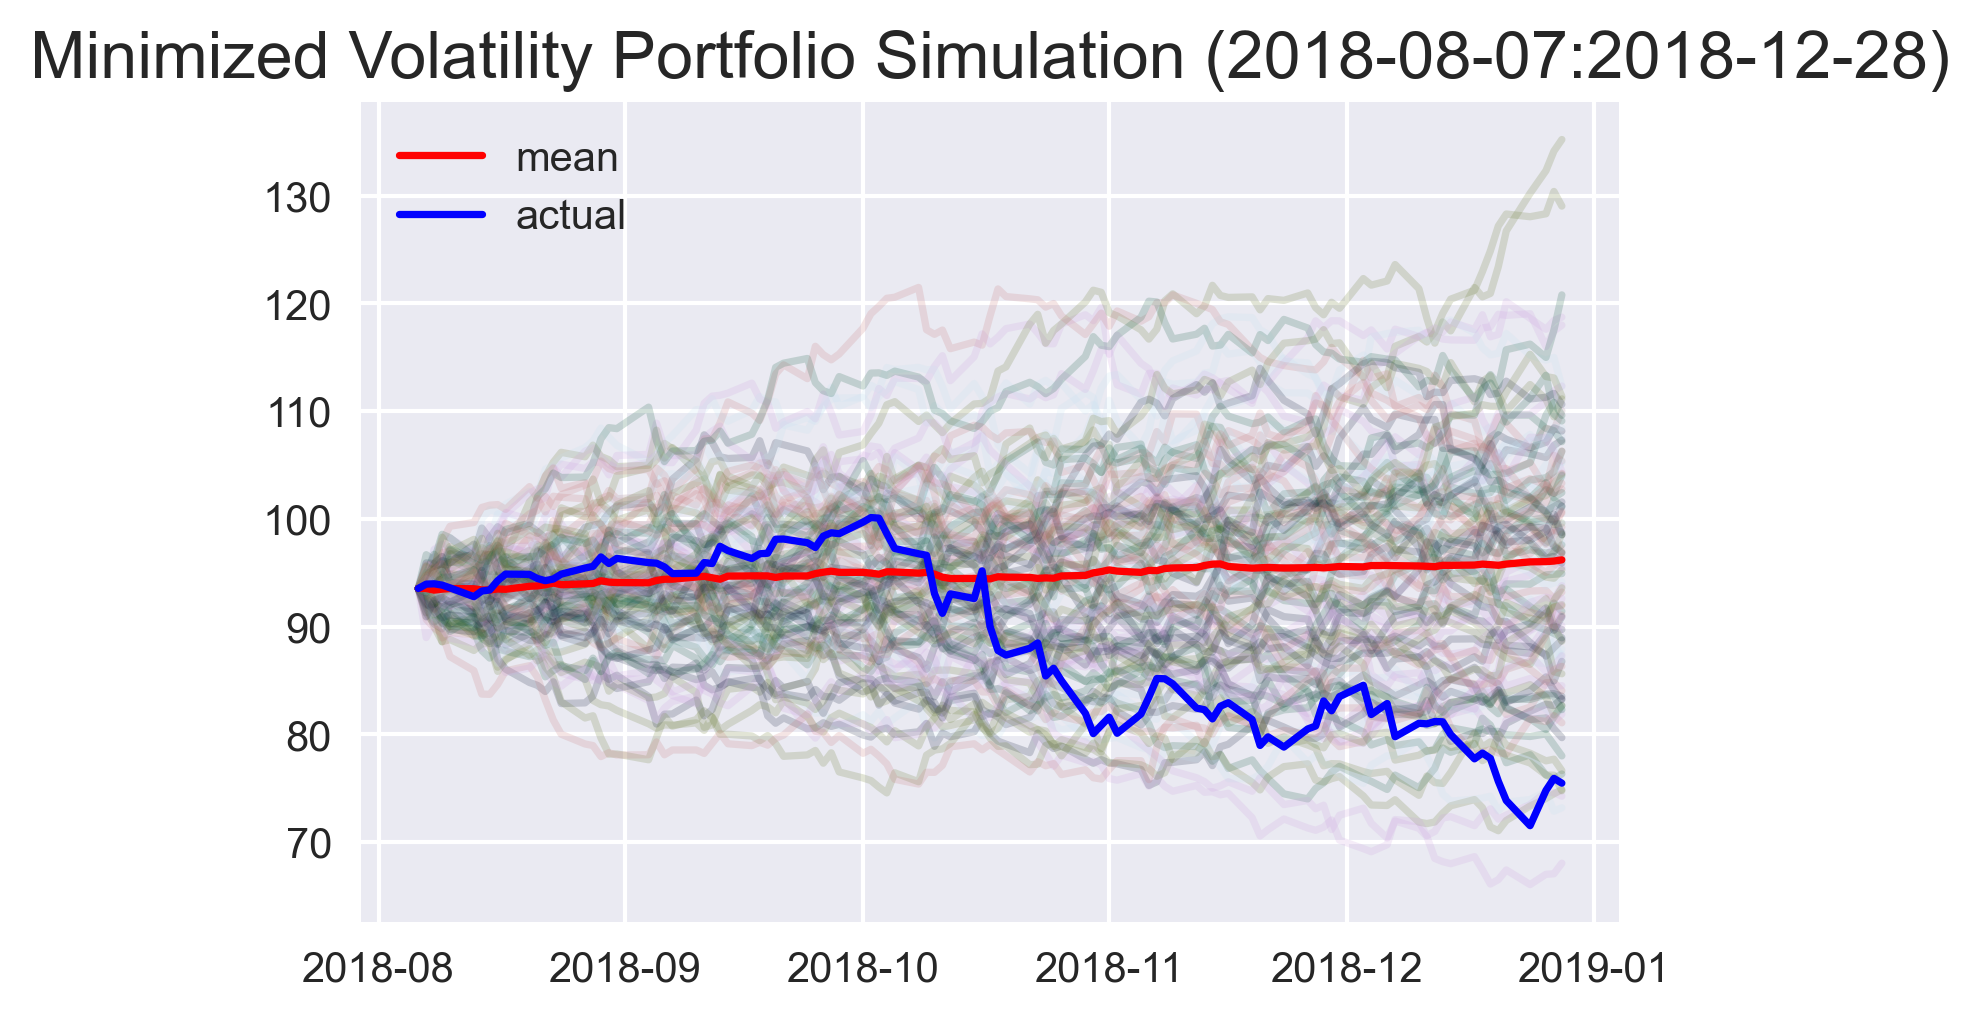

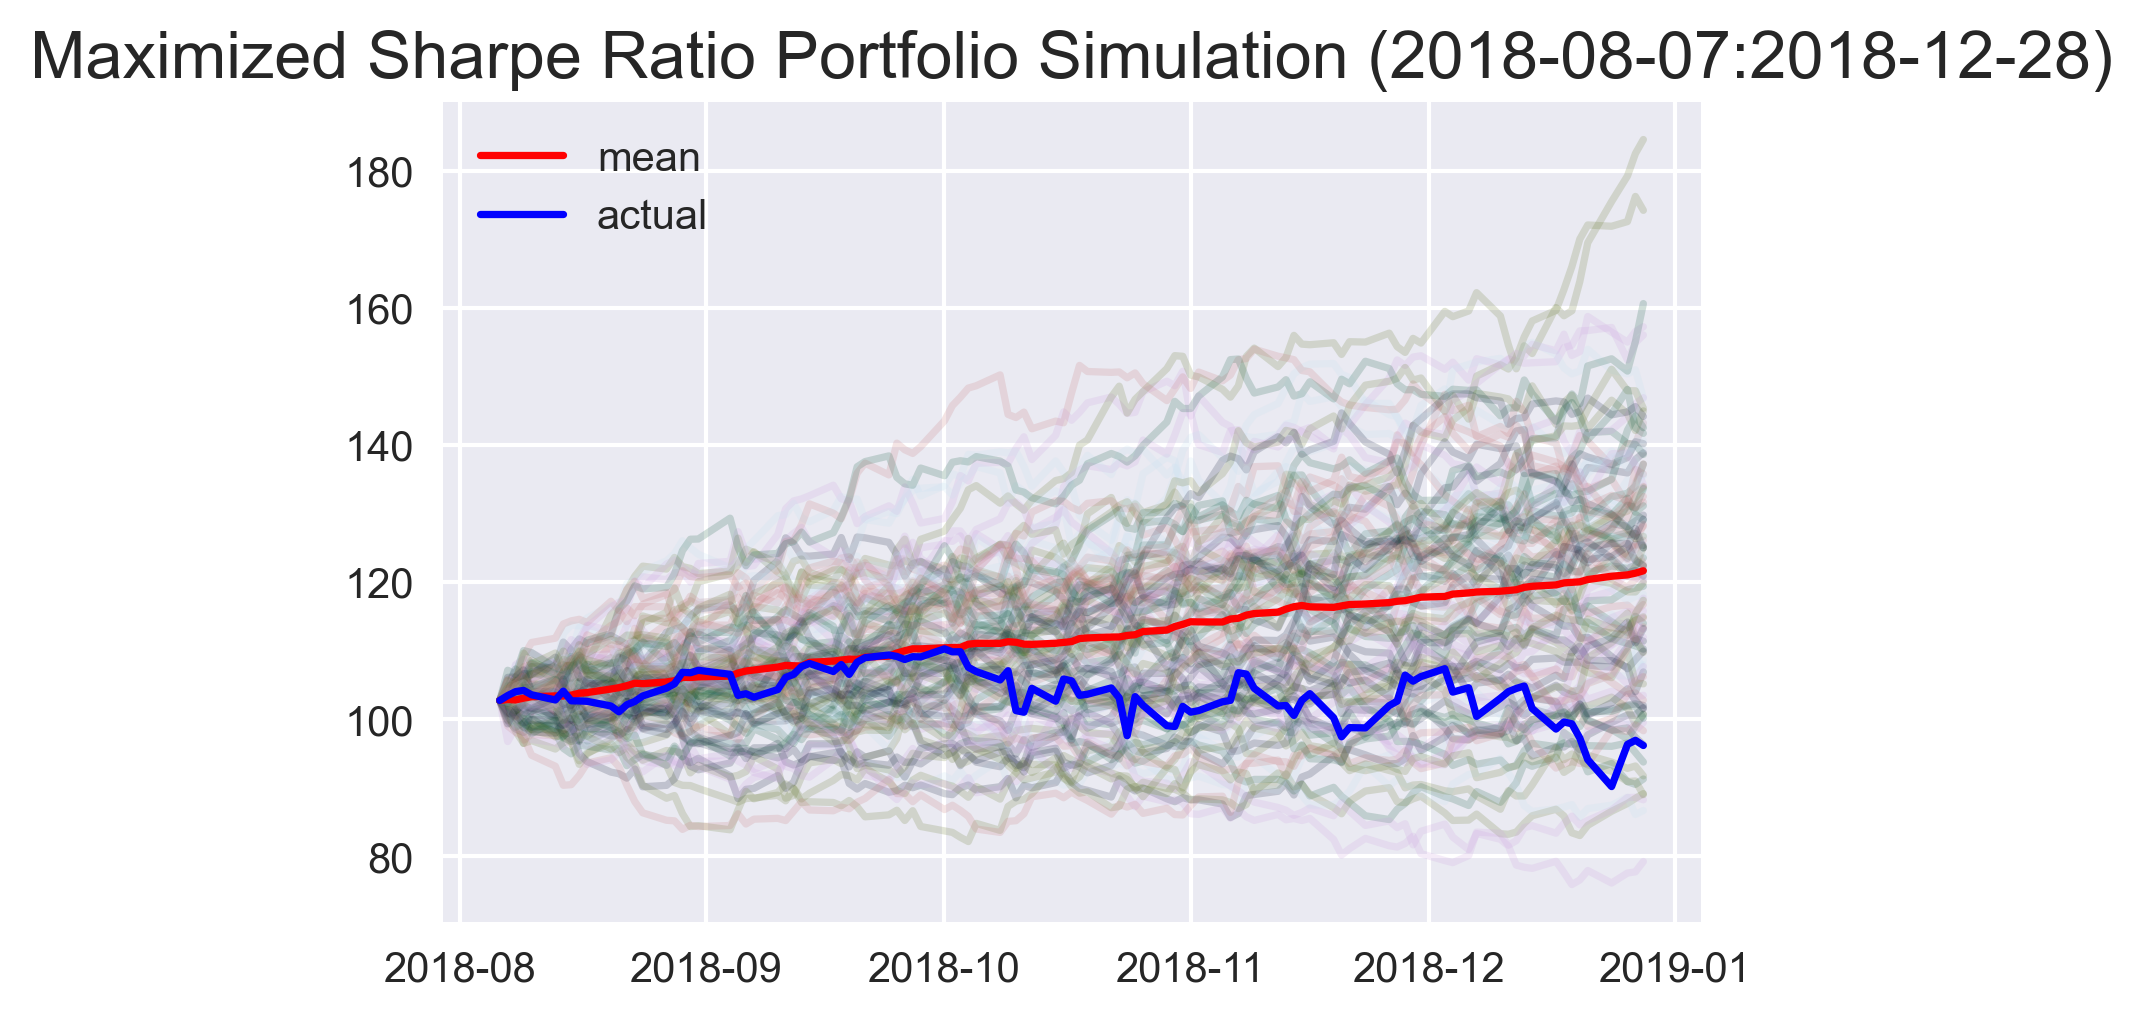

In [16]:
weights_list = [min_vol_port_weights, max_SR_port_weights]

for weights in weights_list:
    
    port_price = pd.Series(np.dot(weights, df_prices['Adj Close'].T))
    port_price.index = df_prices['Adj Close'].index
    port_return = port_price.pct_change().dropna()
    
    train_set = port_return[:int(len(port_return)*0.6)]
    test_set = port_return[int(len(port_return)*0.6):]
    
    T = len(test_set)
    N = len(test_set) 
    s_0 = port_price.loc[train_set.index[-1]]
    num_sims = 100
    mu = train_set.mean()
    sigma = train_set.std()
    
    gbm_simulations = simulate_gbm(s_0, mu, sigma, num_sims, T, N)
    
    # prepare objects for plotting 
    last_train_date = train_set.index[-1].date()
    first_test_date = test_set.index[0].date()
    last_test_date = test_set.index[-1].date()
    
    if weights[0] == min_vol_port_weights[0]:

        plot_title = (f'Minimized Volatility Portfolio Simulation '
                      f'({first_test_date}:{last_test_date})')
        
    else:
        
        plot_title = (f'Maximized Sharpe Ratio Portfolio Simulation '
              f'({first_test_date}:{last_test_date})')


    selected_indices = port_price[last_train_date:last_test_date].index
    index = [date.date() for date in selected_indices]

    gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations), 
                                      index=index)
    # plotting
    ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
    line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                      color='red')
    line_2, = ax.plot(index, port_price[last_train_date:last_test_date], 
                      color='blue')
    ax.set_title(plot_title, fontsize=16)
    ax.legend((line_1, line_2), ('mean', 'actual'))

    plt.tight_layout()
    #plt.savefig('images/ch6_im2.png')
    plt.show()